In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.optimize as optim
import pandas as pd
%matplotlib inline

### Episode 4

In [2]:
def log_k_f(x, k):
    n = len(x)
    return n * np.log(2 * k) - 3 * np.sum(np.log(k * x + 1))

In [3]:
def log_m_f(x, m):
    n = len(x)
    return n * np.log(m) - 2 * np.sum(np.log(m * x + 1))

In [4]:
df = pd.read_excel('Naselenie.xlsx', index_col=0)
df.head()

,Unnamed: 1,Население,Дата,% от населения Земли
№,,,,
1,КНР,1388024000,5 февраля\n2018,0.1838
2,Индия,1342797000,5 февраля\n2018,0.1778
3,США,328279000,5 февраля\n2018,0.0433
4,Индонезия,266276588,5 февраля\n2018,0.0353
5,Пакистан,210068806,5 февраля\n2018,0.0278


In [5]:
X = np.array(df['Население']) / 10 ** 6
X.sort()

Посмотрим на гистограмму и уберем выбросы больше миллиарда жителей (Китай, Индия)

(array([233.,   6.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([4.90000000e-05, 1.38802444e+02, 2.77604839e+02, 4.16407234e+02,
        5.55209629e+02, 6.94012024e+02, 8.32814420e+02, 9.71616815e+02,
        1.11041921e+03, 1.24922160e+03, 1.38802400e+03]),
 <a list of 10 Patch objects>)

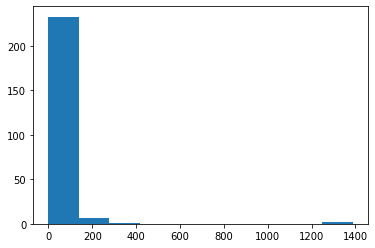

In [6]:
plt.hist(X)

(array([202.,  19.,   8.,   4.,   1.,   2.,   2.,   0.,   1.,   1.]),
 array([4.90000000e-05, 3.28279441e+01, 6.56558392e+01, 9.84837343e+01,
        1.31311629e+02, 1.64139524e+02, 1.96967420e+02, 2.29795315e+02,
        2.62623210e+02, 2.95451105e+02, 3.28279000e+02]),
 <a list of 10 Patch objects>)

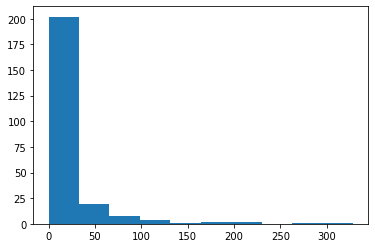

In [7]:
X_trunc = X[X < 1000]
plt.hist(X_trunc)

In [8]:
def log_lambda_n(X):
    numerator = -optim.minimize(lambda k: -log_k_f(X, k), 1, method='L-BFGS-B', bounds=[(1e-8, np.inf)]).fun
    denumerator = -optim.minimize(lambda m: -log_m_f(X, m), 1, method='L-BFGS-B', bounds=[(1e-8, np.inf)]).fun
    return numerator - max(numerator, denumerator)

Используем теорему Уилкса: $k = 2, s = 1$

In [9]:
def rml_test(X, alpha=0.05):
    u_1_alpha = sps.chi2.ppf(1 - alpha, 1)
    stat = -2 * log_lambda_n(X)
    return stat > u_1_alpha

In [10]:
print('Reject H_0:', rml_test(X_trunc, 0.05))

Reject H_0: [ True]


Как видим, мы отвергли $H_0$. Теперь выберем лучшую функцию распределения из второго класса и наложим на выборку

In [11]:
best_m = optim.minimize(lambda m: -log_m_f(X, m), 1, method='L-BFGS-B', bounds=[(1e-8, np.inf)]).x[0]

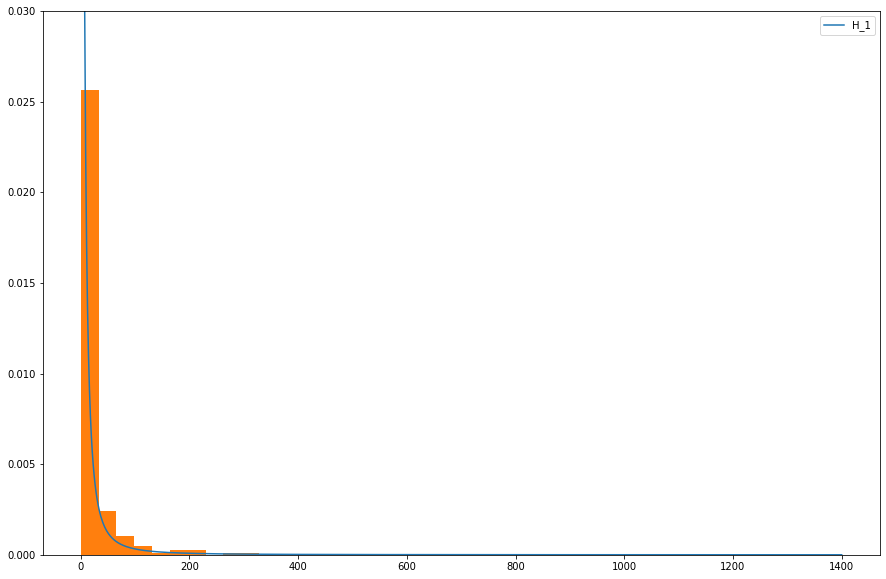

In [12]:
plt.figure(figsize=(15, 10))
grid = np.linspace(2, 1400, 800)
plt.ylim((0, 0.03))
plt.plot(grid, sps.pareto.pdf(grid, 1, -1 / best_m, 1 / best_m), label='H_1')
plt.hist(X_trunc, density=True)
plt.legend()

Потестим наши критерий<br>
Заметили, что данные в задаче функции распределения отвечают за распределение Паретто с разными параметрами.<br>
Посмотрим на ошибки первого и второго рода

In [13]:
def test_reject(it=100, alpha=0.05, size=50):
    true_count = 0
    for _ in range(it):
        sample = sps.pareto.rvs(1, -1, 1, size=size)
        if rml_test(sample, alpha)[0]:
            true_count += 1
    return true_count / it

In [14]:
print('Ошибка второго рода:', 1 - test_reject(100, alpha=0.1))

Ошибка второго рода: 0.38


In [15]:
def test_not_reject(it=100, alpha=0.05, size=50):
    false_count = 0
    for _ in range(it):
        sample = sps.pareto.rvs(2, -1, 1, size=size)
        if not rml_test(sample, alpha)[0]:
            false_count += 1
    return false_count / it

In [16]:
print('Ошибка первого рода:', 1 - test_not_reject(100, alpha=0.1))

Ошибка первого рода: 0.050000000000000044


### Episode 3

$K$ - есть величина веростности двух классов. Предположение о том, как строить критерий: <br>
1. Чтобы ошибка первого рода была alpha, предполагается сгенерировать большое количество выборок $X$ c параметрами, взятыми из априорного распределения, для всех посчитать значение $K$ 

In [17]:
df3 = np.load('data2_3.npy')

In [18]:
N = 13
apr_geom = sps.uniform(loc=0, scale=1)
apr_pois = sps.uniform(loc=0, scale=N)

Denote: $\sum X_i + 1 = s$, $len(X) = n$ <br> <br>

$K = \frac {B(s - n, n + 1) \cdot N \cdot \times (X_i!) \cdot n^s} {GammaIncomplete(s, n\cdot N)} $ <br><br>

Лучше наверное логарифмировать из-за факториалов

In [19]:
import scipy.special as spc
import mpmath

In [33]:
def log_K(X):
    s = np.sum(X) + 1
    n = len(X)
    log = np.log
    
    # log(N) не нужен - так как не функция от выборки
    ret = log(spc.beta(s - n, n + 1)) + np.sum(spc.gammaln(X + 1)) + s * log(n)
    ret -= log(spc.gammainc(s, n * N)) + spc.gammaln(s)
    #ret -= mpmath.log(mpmath.gammainc(s,a=0,b=n * N))
        
    return ret

In [36]:
def build_test(alphas, count=1000, num_samples=50):
    logK = sorted([log_K(sps.geom.rvs(p, size=num_samples)) for p in apr_geom.rvs(size=count)])
    return np.array([float(logK[int(count * alpha)]) for alpha in alphas])

In [37]:
alphas = [0.01, 0.05, 0.1]
test_values = build_test(alphas)
print(test_values)

[2.0860131  5.5982234  7.83966281]


/Users/coolhatsker/Projects/stuff/homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


In [42]:
df_stat = log_K(df3)
print(df_stat < test_values)

[False False  True]


При уровнях значимости 0.01 и 0.05 мы не отвергаем гипотезу о геометрическом распределении, а при 0.1 уже отвергаем. 

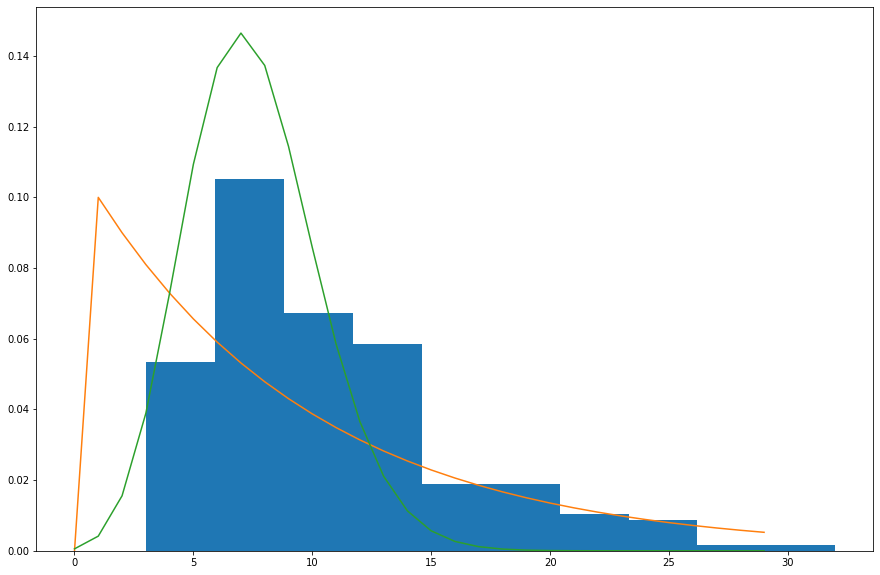

In [103]:
plt.figure(figsize=(15, 10))
plt.hist(df3, density=True)
plt.plot(sps.geom.pmf(range(0, 30), 0.1))
plt.plot(sps.poisson.pmf(range(0, 30), 7.5))

По графику явно видно, что геометрическое распределение при больших $p$ делает упор на первые измерения и с уменьшением его становится как бы более ровным, но вот пик между 5 и 10 объяснить, кажется, не может, а в пуассоновском можно подогнать параметр, чтобы попробовать пик объяснить.

### Episode 2

Пускай каждый пациент, пьющий таблетку, это бернуллиевская случайная величина с вероятностью осложнения $p_0$ для плацебо и $p_i$ для другого препарата. $X_i$ - количество осложнений, $n_i$ - количество участников $i$-го препарата <br>

Рассмотрим гипотезу: $H_0: p_0 \le p_i$ против $H_1: p_0 > p_i$. Понятно, что препарат с большой вероятностью хороший, если мы отвергаем $H_0$ на маленьком уровне значимости (в задаче $\alpha = 0.05$). Рассмотрим критерий: <br>
$\frac {\hat{p_0} - \hat{p_i}} {\sqrt { \hat{p}(1-\hat{p})(\frac{1}{n_0} + \frac{1}{n_i}) } } > z_{1-\alpha}$

$\hat{p_i}=\frac{X_i}{n_i}$<br>
$\hat{p}=\frac{X_i + X_0}{n_i + n_0}$

In [109]:
def test_medicine(n0, x0, ni, xi, name, alpha=0.05):
    p0 = x0/n0
    pi = xi/ni
    p = (x0+xi) / (n0+ni)
    stat = (p0-pi) / (np.sqrt(p * (1-p) * (1/n0 + 1/ni) ))
    z = sps.norm.ppf(1 - alpha)
    if stat > z:
        print('%s is a good medicine' % name)
    else:
        print('I prefer sugar to %s' % name)

In [112]:
test_medicine(80, 45, 75, 26, 'Chlorpromazine')
test_medicine(80, 45, 85, 52, 'Dimenhydrinate')
test_medicine(80, 45, 67, 35, 'Pentobarbital (100 mg)')
test_medicine(80, 45, 85, 37, 'Pentobarbital (150 mg)')

Chlorpromazine is a good medicine
I prefer sugar to Dimenhydrinate
I prefer sugar to Pentobarbital (100 mg)
I prefer sugar to Pentobarbital (150 mg)
